In [1]:
from pathlib import Path
from omegaconf import OmegaConf
import numpy as np
import torch
import matplotlib.pyplot as plt
import wandb

from wyckoff_transformer.tokenization import load_tensors_and_tokenisers
from wyckoff_transformer.generator import WyckoffGenerator
from cascade_transformer.model import CascadeTransformer
from cascade_transformer.dataset import AugmentedCascadeDataset, TargetClass, batched_bincount

device = torch.device("cpu")
run_id = "nonoy0rk"
wandb_run = wandb.Api().run(f"WyckoffTransformer/{run_id}")
config = OmegaConf.create(dict(wandb_run.config))

# The start tokens will be sampled from the train+validation datasets,
# to preserve the sanctity of the test dataset and ex nihilo generation.
tensors, tokenisers = load_tensors_and_tokenisers(config.dataset, config.tokeniser.name)    
generation_size = 15000 #len(next(iter(tensors["test"].values())))*2
del tensors["test"]

max_start = len(tokenisers[config.model.start_token])
start_counts = torch.bincount(tensors["train"][config.model.start_token], minlength=max_start) + \
                torch.bincount(tensors["val"][config.model.start_token], minlength=max_start)
underrepresented = start_counts < 10
start_counts[underrepresented] = 0
print(f"Excluded {underrepresented.sum()} underrepresented start tokens.")
start_distribution = torch.distributions.Categorical(probs=start_counts.float())

model = CascadeTransformer.from_config_and_tokenisers(config, tokenisers, device)
model.load_state_dict(torch.load(Path("runs", run_id, "best_model_params.pt"), map_location=device))
# We need to grab any tensor from the train dataset
max_sequence_len = tensors["train"][config.model.cascade_order[0]].size(1)

masks_dict = {field: tokenisers[field].mask_token for field in config.model.cascade_order}
pad_dict = {field: tokenisers[field].pad_token for field in config.model.cascade_order}
stops_dict = {field: tokenisers[field].stop_token for field in config.model.cascade_order}
num_classes_dict = {field: len(tokenisers[field]) for field in config.model.cascade_order}

generator = WyckoffGenerator(model, config.model.cascade_order, masks_dict, max_sequence_len)

validation_dataset = AugmentedCascadeDataset(
    data=tensors["val"],
    cascade_order=config.model.cascade_order,
    masks=masks_dict,
    pads=pad_dict,
    stops=stops_dict,
    num_classes=num_classes_dict,
    start_field=config.model.start_token,
    augmented_field=config.tokeniser.augmented_token_fields[0],
    dtype=torch.long,
    device=device)

Excluded 58 underrepresented start tokens.


At max element count: 861
tensor(0.)


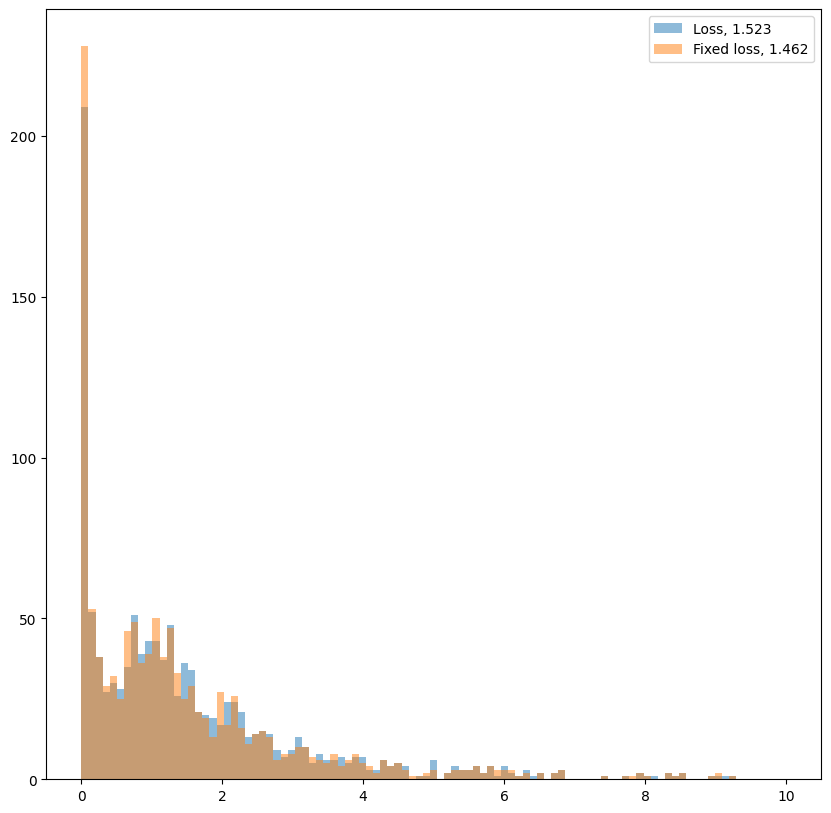

In [36]:
known_seq_len = 6
known_cascade_len = 0
with torch.no_grad():
    start_tokens, masked_data, target = validation_dataset.get_masked_multiclass_cascade_data(
                            known_seq_len, known_cascade_len,
                            target_type=TargetClass.NextToken, multiclass_target=True)
    logits = model(start_tokens, masked_data, None, known_cascade_len)
    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")
    loss = loss_fn(logits, target)
    element_present = batched_bincount(masked_data[0], dim=1, max_value=num_classes_dict["elements"], dtype=torch.bool)
    element_counts = element_present.sum(dim=1)
    # at max element count
    # ternary + MASK
    at_max_element_count = element_counts == 4
    print(f"At max element count: {at_max_element_count.sum()}")
    fixed_logits = logits.clone()

    element_present |= ~at_max_element_count[:, None]
    element_present[:, tokenisers["elements"].stop_token] = True
    print(target[~element_present].max())
    fixed_logits[~element_present] -= 10
    fixed_loss = loss_fn(fixed_logits, target)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    bins = np.linspace(0, 10, 100)
    ax.hist(loss.cpu().numpy(), bins=bins, alpha=0.5, label=f"Loss, {loss.mean().item():.3f}")
    ax.hist(fixed_loss.cpu().numpy(), bins=bins, alpha=0.5, label=f"Fixed loss, {fixed_loss.mean().item():.3f}")
    ax.legend()

In [34]:
target[~element_present].max()

tensor(0.)

In [33]:
logits[643]

tensor([ -4.0312, -11.0994,   2.2523,   1.0409,   2.0111,   1.5558,   2.5604,
         -1.2986,  -3.0392,  -4.8223,   3.8653,   7.2354,   4.3229,   1.7210,
          1.6754,  -4.0792,  -3.1583,  -1.2237,   2.0977,   7.1409,   2.4962,
          4.7637,   3.5087,   4.8242,   3.1974,   3.7222,   3.8034,   3.3081,
          3.3005,   2.8811,   0.1302,   1.3950,  -1.5820, -10.5776,  -4.3399,
         -3.6200,   0.3189,   6.8556,   3.5680,   3.1446,   1.6643,   3.3728,
          3.5670,   1.3421,   1.5107,   1.0620,   4.1449,   3.6082,   3.3962,
          0.2069,  -2.6082,  -9.6097,  -3.7071,  -1.2910,  -1.8372,   3.0089,
         -0.6446,  -2.1979,  -6.5931,  -0.9168,  -4.4278,  -0.6325,   0.7893,
         -0.9153,  -1.5817,  -2.6979,  -3.3178,  -0.7592,  -4.0201,   2.6068,
          0.8521,   1.5527,   0.0640,   3.6470,   5.2114,   5.8163,   2.3340,
         -3.3345,  -0.3458,   2.8163,   3.0696,  -7.8520,   1.1709,  -5.1957,
          1.8759,  -3.4391,  -4.3078, -12.1324,   3.0765, -12.14

In [28]:
target[643]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
at_max_element_count[643]

tensor(True)

In [30]:
element_present[643]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True])